In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from SmallData import SmallDataset
from SmallUnet import SimpleUNet
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback

class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss_epoch")
        val_loss = metrics.get("val_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        if val_loss is not None:
            self.val_losses.append(val_loss.item())


dataset_path = "dataset/multispectral_field_images"

dataset = SmallDataset(dataset_path)
print(dataset)

train_loader, val_loader, test_loader = dataset.produce_dataloaders()
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=7, out_channels=7, base_channels=32):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.out_conv = nn.Conv2d(base_channels, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = self.out_conv(d1)
        return out

# -----------------------------
# 3️⃣ PyTorch Lightning Module
# -----------------------------
class UNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SimpleUNet()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        # Print all metrics for this epoch
        metrics = self.trainer.callback_metrics  # dictionary of all logged metrics
        epoch = self.current_epoch
        metric_str = ", ".join([f"{k}: {v:.6f}" for k, v in metrics.items()])
        print(f"Epoch {epoch+1}: {metric_str}")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# -----------------------------
# 5️⃣ Logger & Checkpoint
# -----------------------------
logger = TensorBoardLogger("tb_logs", name="unet_model")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
history_cb = HistoryCallback()

# -----------------------------
# 6️⃣ Trainer
# -----------------------------
trainer = pl.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[checkpoint_callback, history_cb],
    accelerator="cpu",   # explicitly use CPU
    devices=1            # one CPU device
)

model = UNetLightning()
history = trainer.fit(model, train_loader, val_loader)

# -----------------------------
# 7️⃣ Model Architecture Visualization
# -----------------------------
from torchsummary import summary
x = torch.randn(1, 7, 96, 96)
summary(model.model, input_size=(7, 96, 96))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | SimpleUNet | 467 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
467 K     Trainable params
0         Non-trainable params
467 K     Total params
1.872     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


torch.Size([1, 7, 96, 96])


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jrosa/AGH_FILES/GSN-2025W-PuchaczPansharpening/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: train_loss: 53828592.000000, train_loss_step: 5215095.500000, val_loss: 5369138.000000, train_loss_epoch: 53828592.000000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: train_loss: 3332570.500000, train_loss_step: 1645966.000000, val_loss: 2397311.500000, train_loss_epoch: 3332570.500000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: train_loss: 1864426.500000, train_loss_step: 4209372.500000, val_loss: 6625443.500000, train_loss_epoch: 1864426.500000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: train_loss: 1798175.375000, train_loss_step: 1139702.500000, val_loss: 1131450.375000, train_loss_epoch: 1798175.375000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: train_loss: 1136054.250000, train_loss_step: 1805732.625000, val_loss: 1946650.750000, train_loss_epoch: 1136054.250000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: train_loss: 1217588.375000, train_loss_step: 953708.625000, val_loss: 1648915.250000, train_loss_epoch: 1217588.375000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: train_loss: 1387483.750000, train_loss_step: 622696.625000, val_loss: 750905.500000, train_loss_epoch: 1387483.750000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: train_loss: 746185.125000, train_loss_step: 675920.562500, val_loss: 693833.875000, train_loss_epoch: 746185.125000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: train_loss: 754055.187500, train_loss_step: 1306777.875000, val_loss: 930640.812500, train_loss_epoch: 754055.187500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: train_loss: 846306.250000, train_loss_step: 374927.937500, val_loss: 614592.625000, train_loss_epoch: 846306.250000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: train_loss: 738850.250000, train_loss_step: 588074.062500, val_loss: 732539.187500, train_loss_epoch: 738850.250000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: train_loss: 785907.500000, train_loss_step: 635611.625000, val_loss: 585310.437500, train_loss_epoch: 785907.500000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: train_loss: 603140.000000, train_loss_step: 253652.968750, val_loss: 682581.062500, train_loss_epoch: 603140.000000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: train_loss: 688160.187500, train_loss_step: 482242.187500, val_loss: 501479.562500, train_loss_epoch: 688160.187500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: train_loss: 702606.062500, train_loss_step: 169244.140625, val_loss: 1113103.875000, train_loss_epoch: 702606.062500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: train_loss: 1689229.750000, train_loss_step: 94678.828125, val_loss: 558052.437500, train_loss_epoch: 1689229.750000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: train_loss: 505255.937500, train_loss_step: 268834.093750, val_loss: 456774.093750, train_loss_epoch: 505255.937500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: train_loss: 763132.687500, train_loss_step: 1679224.500000, val_loss: 1389828.125000, train_loss_epoch: 763132.687500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: train_loss: 588510.687500, train_loss_step: 1019972.187500, val_loss: 828815.187500, train_loss_epoch: 588510.687500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: train_loss: 631375.562500, train_loss_step: 173101.843750, val_loss: 675859.000000, train_loss_epoch: 631375.562500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: train_loss: 642400.062500, train_loss_step: 1296594.500000, val_loss: 902193.562500, train_loss_epoch: 642400.062500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: train_loss: 522263.062500, train_loss_step: 126809.078125, val_loss: 372023.718750, train_loss_epoch: 522263.062500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: train_loss: 1111074.500000, train_loss_step: 238447.937500, val_loss: 554305.125000, train_loss_epoch: 1111074.500000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: train_loss: 691747.562500, train_loss_step: 228158.546875, val_loss: 373444.000000, train_loss_epoch: 691747.562500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: train_loss: 404382.843750, train_loss_step: 364021.968750, val_loss: 446383.718750, train_loss_epoch: 404382.843750


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: train_loss: 602486.625000, train_loss_step: 285381.156250, val_loss: 426050.968750, train_loss_epoch: 602486.625000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: train_loss: 390009.906250, train_loss_step: 398210.093750, val_loss: 767215.562500, train_loss_epoch: 390009.906250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: train_loss: 476414.812500, train_loss_step: 470872.968750, val_loss: 505144.531250, train_loss_epoch: 476414.812500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: train_loss: 594604.187500, train_loss_step: 389266.656250, val_loss: 655249.437500, train_loss_epoch: 594604.187500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: train_loss: 492030.531250, train_loss_step: 388824.687500, val_loss: 513606.781250, train_loss_epoch: 492030.531250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: train_loss: 655132.125000, train_loss_step: 445024.875000, val_loss: 885449.687500, train_loss_epoch: 655132.125000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: train_loss: 482150.281250, train_loss_step: 4871760.500000, val_loss: 20322168.000000, train_loss_epoch: 482150.281250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: train_loss: 2136598.500000, train_loss_step: 357896.437500, val_loss: 508168.968750, train_loss_epoch: 2136598.500000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: train_loss: 410957.531250, train_loss_step: 331060.437500, val_loss: 384599.968750, train_loss_epoch: 410957.531250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: train_loss: 529674.625000, train_loss_step: 119083.320312, val_loss: 359601.281250, train_loss_epoch: 529674.625000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: train_loss: 499378.281250, train_loss_step: 964015.750000, val_loss: 587804.687500, train_loss_epoch: 499378.281250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: train_loss: 475771.437500, train_loss_step: 719968.625000, val_loss: 301808.187500, train_loss_epoch: 475771.437500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: train_loss: 355308.656250, train_loss_step: 903335.125000, val_loss: 1077180.750000, train_loss_epoch: 355308.656250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: train_loss: 743290.875000, train_loss_step: 228940.578125, val_loss: 354339.687500, train_loss_epoch: 743290.875000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: train_loss: 447237.156250, train_loss_step: 273620.187500, val_loss: 747017.375000, train_loss_epoch: 447237.156250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: train_loss: 337080.656250, train_loss_step: 247604.515625, val_loss: 680023.250000, train_loss_epoch: 337080.656250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: train_loss: 337583.781250, train_loss_step: 94135.539062, val_loss: 737573.875000, train_loss_epoch: 337583.781250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: train_loss: 286520.250000, train_loss_step: 195021.937500, val_loss: 252151.796875, train_loss_epoch: 286520.250000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: train_loss: 836075.375000, train_loss_step: 145365.156250, val_loss: 2924547.500000, train_loss_epoch: 836075.375000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: train_loss: 685319.750000, train_loss_step: 224374.250000, val_loss: 280341.656250, train_loss_epoch: 685319.750000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: train_loss: 275264.750000, train_loss_step: 246716.437500, val_loss: 268093.968750, train_loss_epoch: 275264.750000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: train_loss: 313270.531250, train_loss_step: 71903.984375, val_loss: 968469.500000, train_loss_epoch: 313270.531250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: train_loss: 408938.375000, train_loss_step: 641712.000000, val_loss: 486363.500000, train_loss_epoch: 408938.375000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49: train_loss: 350284.875000, train_loss_step: 317872.718750, val_loss: 239257.281250, train_loss_epoch: 350284.875000


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50: train_loss: 291446.562500, train_loss_step: 396796.468750, val_loss: 329185.468750, train_loss_epoch: 291446.562500
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]           2,048
              ReLU-2           [-1, 32, 96, 96]               0
            Conv2d-3           [-1, 32, 96, 96]           9,248
              ReLU-4           [-1, 32, 96, 96]               0
         MaxPool2d-5           [-1, 32, 48, 48]               0
            Conv2d-6           [-1, 64, 48, 48]          18,496
              ReLU-7           [-1, 64, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          36,928
              ReLU-9           [-1, 64, 48, 48]               0
        MaxPool2d-10           [-1, 64, 24, 24]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 2

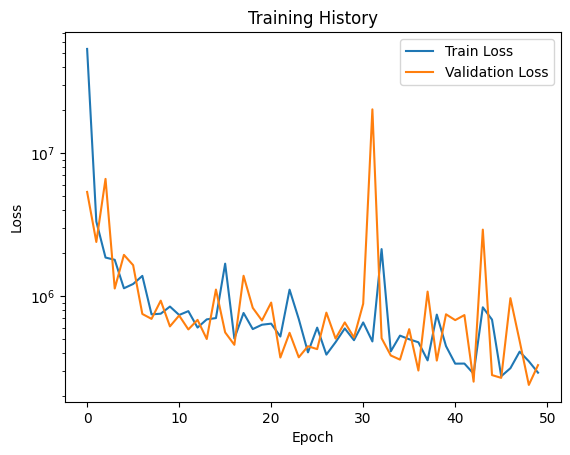

In [4]:
plt.figure()
plt.semilogy(history_cb.train_losses, label="Train Loss")
plt.semilogy(history_cb.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")
plt.legend()
plt.show()


/home/jrosa/AGH_FILES/GSN-2025W-PuchaczPansharpening/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


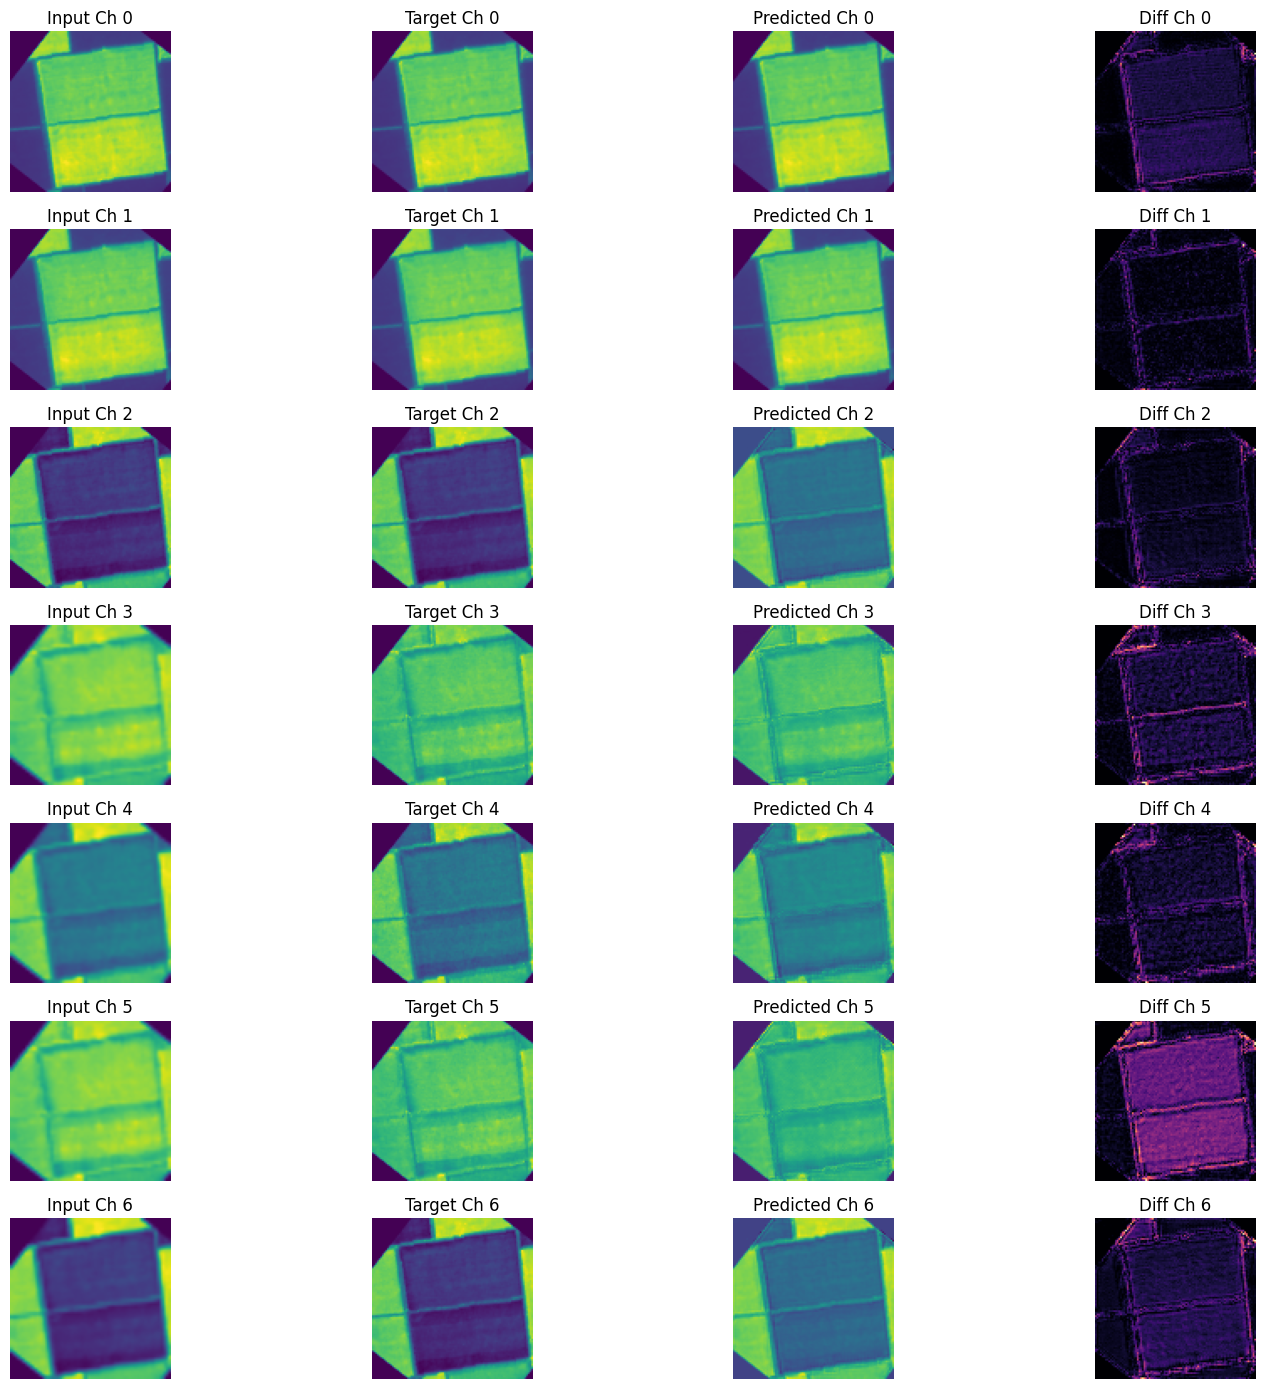

In [11]:
# Get one batch from validation loader
x, y = next(iter(test_loader))  # x: (B, 7, 96, 96), y: (B, 7, 96, 96)
x, y = x.to("cpu"), y.to("cpu")

# Pick the first sample in batch
input_img = x[8]    # (7, 96, 96)
target_img = y[8]   # (7, 96, 96)

# Get model prediction
model.eval()
with torch.no_grad():
    pred_img = model(input_img.unsqueeze(0)).squeeze(0)  # (7, 96, 96)

# Compute difference (absolute error)
diff_img = torch.abs(target_img - pred_img)  # (7, 96, 96)

# Plot input, target, predicted, and difference
num_channels = input_img.shape[0]
fig, axes = plt.subplots(num_channels, 4, figsize=(16, num_channels*2))

for c in range(num_channels):
    axes[c, 0].imshow(input_img[c].numpy(), cmap="viridis")
    axes[c, 0].set_title(f"Input Ch {c}")
    axes[c, 0].axis("off")

    axes[c, 1].imshow(target_img[c].numpy(), cmap="viridis")
    axes[c, 1].set_title(f"Target Ch {c}")
    axes[c, 1].axis("off")

    axes[c, 2].imshow(pred_img[c].numpy(), cmap="viridis")
    axes[c, 2].set_title(f"Predicted Ch {c}")
    axes[c, 2].axis("off")

    axes[c, 3].imshow(diff_img[c].numpy(), cmap="magma")
    axes[c, 3].set_title(f"Diff Ch {c}")
    axes[c, 3].axis("off")

plt.tight_layout()
plt.show()
